In [54]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader
from patsy import dmatrix
import torch
sys.path.append(os.path.abspath('../src'))

from data_tools.data_utils import create_data_split

In [2]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40

create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [130]:
class ReportingDataset():
    def __init__(self, df, D):
        self.df = df.copy()
        self.D = D
        self.max_val = self.df.values.max()
    
    def get_obs(self, idx, n_points, norm=False, mask=False):
        # Ignore first D days to ensure full matrix
        t = idx + self.D


        # Create reporting triangle for day t
        matrix = self.df.iloc[t - n_points + 1: t + 1, :self.D].values
        
        # Mask last D days
        if mask:
            matrix[-self.D:] = self.mask_matrix(matrix[-self.D:])

        if norm:
            return matrix / self.max_val
        else:
            return matrix
    
    def get_y(self, idx):
        t = idx + self.D
        return self.df.iloc[t].sum()

    def get_date(self, idx):
        t = idx + self.D
        return self.df.index[t]


    def get_past_triangles(self, idx, n_points=1, norm=True):
        assert n_points >= 1, "n must be non-negative"
        assert idx + 1 >= n_points, "idx must be at least as big as number of points"
        triangles = np.zeros(shape=(n_points, self.D, self.D))
        t_vals = np.arange(idx-n_points+1, idx+1)
        for i, t in enumerate(t_vals):
            triangles[i, :, :] = self.get_obs(t, n_points=self.D, norm=norm)

        return triangles

    def get_masked_matrix(self, mask):
        for i in range(self.D):
            for j in range(self.D):
                if i + j > self.D - 1:
                    mask[i, j] = False
        return mask


data_obj = ReportingDataset(complete_df, D=trunc_D)

In [ ]:
def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        init="adapt_diag",
        chains=2,
        draws=300,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def get_train_post(var, train_post):
    return np.percentile(train_post[var], 50, axis=-1)


def BNN_nowcast(data_obj, t, n_points, progressbar=True, mask=False):
    
    obs = data_obj.get_obs(t, n_points)
    triangles = data_obj.get_past_triangles(t, n_points)

    mask_matrix = np.ones_like(obs, dtype=bool)
    if mask:
        mask_matrix = data_obj.get_masked_matrix(mask_matrix)

    # weight likelihood
    weights = np.ones_like(obs[mask_matrix])
    weights[-1]

    t = np.arange(0, n_points)
    t_week = t % 7                      # day of the week number

    # Global trend spline 3 degree polynomial
    spline_trend = dmatrix(
        "bs(t, df=10, degree=3, include_intercept=False)", {"t": t}, return_type='dataframe'
    )
    X_trend = np.asarray(spline_trend)

    # cc is syclic cubic spline
    spline_week = dmatrix(
        "cc(t_week, df=7)", {"t_week": t_week}, return_type='dataframe'
    )
    X_week = np.asarray(spline_week)


    with pm.Model() as model:

        # Trend spline coefficients
        sigma_trend = pm.HalfNormal("sigma_trend", 2)
        beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
        
        # Cyclic spline coefficients (seasonality)
        sigma_week = pm.HalfNormal("sigma_week", 2)
        beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
        

        intercept = pm.Normal("intercept", mu=0, sigma=10)
        log_lam = pm.Deterministic(
            "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week) + intercept
        )
        lam = pm.Deterministic("lam", pm.math.exp(pm.math.clip(log_lam, -5, 10)))


        # Neural net proportions
        T, D, F = triangles.shape
        n_hidden = 8
        

        h0 = pm.math.flatten(triangles, ndim=2)  # (T, D*F)

        net_sd = 0.3
        W1 = pm.Normal("W1", 0, net_sd, shape=(D*F, n_hidden))
        b1_net = pm.Normal("b1_net", 0, net_sd, shape=(n_hidden,))
        h1 = silu(pm.math.dot(h0, W1) + b1_net)

        W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, D))
        b2_net = pm.Normal("b2_net", 0, net_sd, shape=(D,))
        p_raw = pm.math.dot(h1, W2) + b2_net

        # Day of week effect
        t_week_onehot = np.eye(7)[t_week]
        W_dow = pm.Normal("W_dow", 0, net_sd, shape=(7, D))
        p_dow = pm.math.dot(t_week_onehot, W_dow)

        p_raw = pm.math.clip(p_raw + p_dow, -10, 10)
        p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

        mu = pm.Deterministic("mu", lam[:, None] * p)
        mu_clipped = pm.math.clip(mu, 1e-3, 1e5)

        alpha = pm.Exponential("alpha", 2)
        z = pm.NegativeBinomial("z", mu_clipped[mask_matrix], alpha, observed=obs[mask_matrix])

        idata = pm.sample(progressbar=progressbar, compile="jax", **sampler_kwargs())
        return idata

    
def plot(data_obj, t, n_points, idata):

    lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']
    BNN_preds = np.percentile(lam_post_samples, 50, axis=1)
    BNN_lower = np.percentile(lam_post_samples, 97.5, axis=1)
    BNN_upper = np.percentile(lam_post_samples, 2.5, axis=1)

    PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
    PNN_df = PNN_df.iloc[trunc_D + t - n_points + 1:trunc_D + t+1]
    PNN_preds = PNN_df['preds']

    y_plot = [data_obj.get_y(idx) for idx in np.arange(t-n_points+1, t+1)]
    dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t-n_points, t)]


    plt.plot(dates, y_plot, label='y')

    plt.plot(dates, BNN_preds, label='BNN', color='green')
    # plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



    plt.plot(dates, PNN_preds, label='PNN', color='orange')
    # plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


    plt.legend()
    plt.tight_layout()
    plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
    plt.xlabel("Date of First Symptom")
    plt.ylabel("Case Count")
    plt.xticks(rotation=45)
    plt.show()



Progress,Draws,Divergences,Step Size,Gradients/Draw
,800,0,0.01,511
,800,0,0.01,511


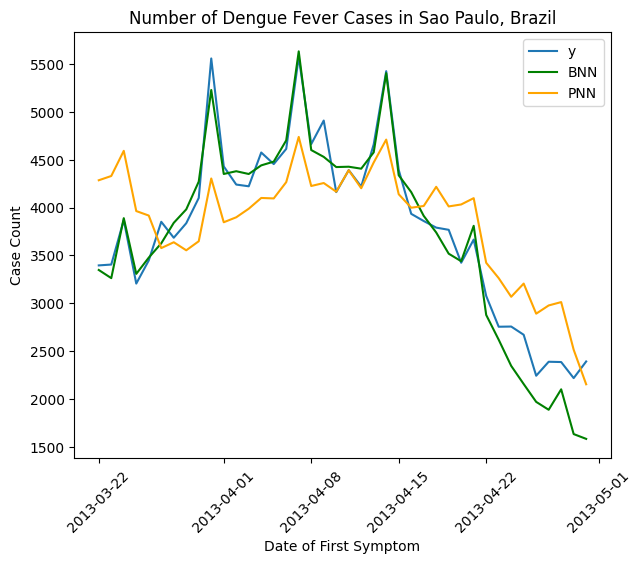

In [147]:
n_points = 40
t = 41

idata = BNN_nowcast(data_obj, t, n_points, mask=True)
plot(data_obj, t, n_points, idata)
